In [1]:
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import unidecode
fig, ax=plt.subplots()
pd.set_option('display.max_columns', None)
import pandas_profiling as pp

In [2]:
df=pd.read_excel('/./Data/Processed/2010-2019.xlsx')

In [3]:
#removing records in which Super over or DL rule were applied
df.drop(df[((df.SO==1) | (df.DL==1))].index,axis=0,inplace=True)
df.drop(columns=['DL','SO'],axis=1, inplace=True)

In [4]:
df2019=df[df.Year==2019]

In [5]:
from sklearn.feature_extraction import DictVectorizer
def encodedf(Xdf):
    vec=DictVectorizer(sparse=False)
    X_dict = Xdf.to_dict("records")
    X_encoded = vec.fit_transform(X_dict)
    df_vec=pd.DataFrame(X_encoded)
    colMap={}
    for key in vec.vocabulary_:
        colMap[vec.vocabulary_[key]]=key
    return df_vec.rename(columns=colMap)

In [6]:
modelColumns=['Year','Home Team','Away Team','Chase','DayNight','Win','League Match','HBatting',
              'HBowling','HFielding','ABatting','ABowling','AFielding']
dfModel=df[modelColumns]
dfEncoded=encodedf(dfModel)
dfEncoded.head()

,ABatting,ABowling,AFielding,Away Team=CSK,Away Team=DD,Away Team=GL,Away Team=KKR,Away Team=KP,Away Team=KTK,Away Team=KXIP,Away Team=MI,Away Team=PW,Away Team=PWI,Away Team=RCB,Away Team=RPS,Away Team=RR,Away Team=SH,Away Team=SRH,Chase,DayNight,HBatting,HBowling,HFielding,Home Team=CSK,Home Team=DD,Home Team=GL,Home Team=KKR,Home Team=KP,Home Team=KTK,Home Team=KXIP,Home Team=MI,Home Team=PW,Home Team=PWI,Home Team=RCB,Home Team=RPS,Home Team=RR,Home Team=SH,Home Team=SRH,League Match,Win,Year
0,544.0,587.0,77.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,927.0,812.0,147.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2019.0
1,361.0,928.5,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,876.0,560.0,125.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2019.0
2,782.0,294.5,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,690.0,663.5,147.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2019.0
3,631.0,411.0,77.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,676.5,694.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2019.0
4,927.0,812.0,147.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,782.0,229.5,77.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2019.0


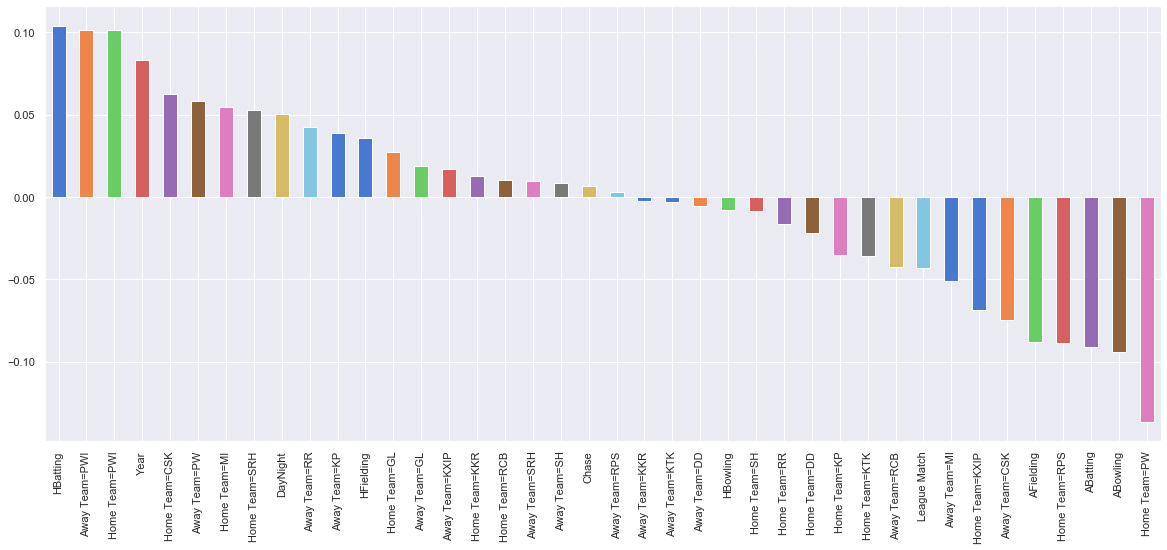

In [95]:
dims = (20, 8)
sns.set(style='darkgrid',palette="muted")
fig, ax=plt.subplots(figsize=dims)
dfEncoded.corrwith(dfEncoded.Win).sort_values(ascending = False)[1:].plot(kind='bar')

In [7]:
X_train=dfEncoded[dfEncoded.Year!=2019].drop('Win', axis=1)
y_train=dfEncoded[dfEncoded.Year!=2019].Win
X_test=dfEncoded[dfEncoded.Year==2019].drop('Win', axis=1)
y_test=dfEncoded[dfEncoded.Year==2019].Win

In [8]:
X_test.shape

(57, 40)

In [9]:
#plot precicion, recall and thresholds
#predicted_proba[:,1]
def plotPrecisionRecallThreshold(y_test, pred_prob):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, pred_prob) 
   #retrieve probability of being 1(in second column of probs_y)
    pr_auc = metrics.auc(recall, precision)
    plt.title("Precision-Recall vs Threshold Chart")
    plt.plot(thresholds, precision[: -1], "b--", label="Precision")
    plt.plot(thresholds, recall[: -1], "r--", label="Recall")
    plt.ylabel("Precision, Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0,1])
    
def plotROC(y_test,pred_prob):
    fpr, tpr, threshold=metrics.roc_curve(y_test,pred_prob)
    plt.title("ROC Curve")
    sns.lineplot(x=fpr,y=tpr,palette="muted")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    
def areaUnderROC(y_test, pred_prob):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, pred_prob) 
    return metrics.auc(recall, precision)

def cm(y_test,prediction_test):
    arr=metrics.confusion_matrix(y_test,prediction_test)
    df_cm = pd.DataFrame(arr, range(2),range(2))
    #plt.figure(figsize = (10,7))
    sns.set(font_scale=1)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for threshold: .5")

In [10]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
model = LogisticRegression(random_state=232,penalty='none', solver='saga')
result = model.fit(X_train, y_train)

In [11]:
prediction_test = model.predict(X_train)
# Print the prediction accuracy
print('training accuracy: %.2f' %metrics.accuracy_score(y_train, prediction_test))
#df['logistic']=model.predict(X)
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print('test accuracy: %.2f' %metrics.accuracy_score(y_test, prediction_test))

training accuracy: 0.62
test accuracy: 0.51


In [13]:
df2019['Logistic']=prediction_test
df2019['pLogistic']=model.predict_proba(X_test)[:,1]

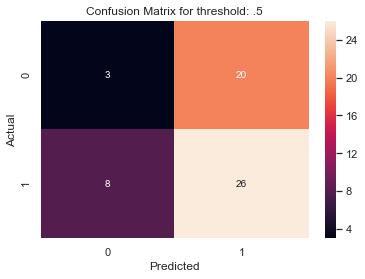

In [14]:
cm(y_test,prediction_test)

area under curve : 0.63


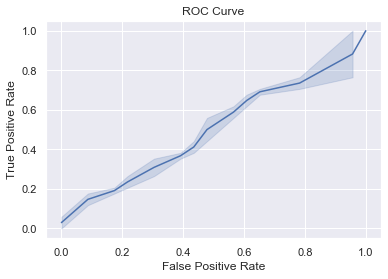

In [15]:
plotROC(y_test, df2019['pLogistic'])
print('area under curve : %.2f' %areaUnderROC(y_test, df2019['pLogistic']) )

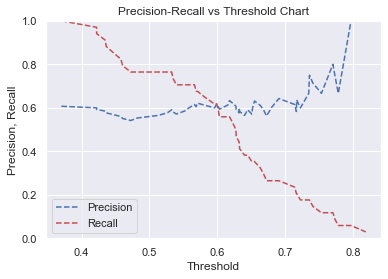

In [16]:
plotPrecisionRecallThreshold(y_test, df2019['pLogistic'])

In [17]:
model.coef_[0]

array([-7.76928787e-04, -1.26168055e-03, -5.12555133e-05, -6.53346302e-05,
        1.14522214e-05,  3.43349351e-05, -3.33458960e-06,  4.16472844e-05,
       -1.67616307e-05,  1.10418467e-05,  1.52372743e-05,  5.09551618e-05,
        6.45228823e-05, -1.77126185e-04, -1.05139798e-05,  4.50050927e-05,
       -4.06855958e-05,  3.90710547e-05, -2.75698757e-05,  1.38465378e-04,
        2.40315777e-03, -6.51406874e-04, -4.94831364e-03,  8.27317355e-05,
        1.59494484e-05,  1.13913728e-05,  2.83138635e-05, -7.03012254e-05,
       -3.25936616e-05, -4.99018329e-05,  4.33216337e-05, -1.92315357e-04,
        1.08407063e-04,  5.63690896e-05, -7.84311224e-05, -1.11364184e-05,
        3.86772368e-05,  4.90293171e-05, -1.01785775e-04,  4.34020964e-04])

AxesSubplot(0.125,0.125;0.775x0.755)


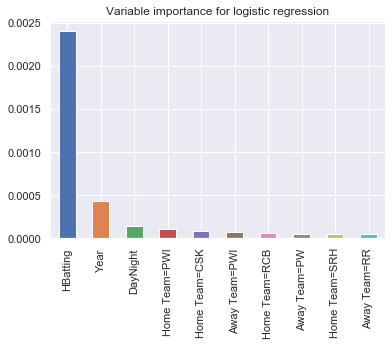

In [18]:
weights = pd.Series(model.coef_[0],index=X_train.columns)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar',title='Variable importance for logistic regression'))

In [19]:
#logistic regression CV. L1 Lasso
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(Cs=np.linspace(1e-3,1,50),cv=5,penalty='l1',solver='liblinear', random_state=232)
result = model.fit(X_train, y_train)
model.C_

array([0.12332653])

In [20]:
prediction_test = model.predict(X_train)
# Print the prediction accuracy
print('training accuracy: %.2f' %metrics.accuracy_score(y_train, prediction_test))
#df['logistic']=model.predict(X)
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print('test accuracy: %.2f' %metrics.accuracy_score(y_test, prediction_test))

training accuracy: 0.62
test accuracy: 0.51


In [21]:
df2019['L1Logistic']=prediction_test
df2019['pL1Logistic']=model.predict_proba(X_test)[:,1]

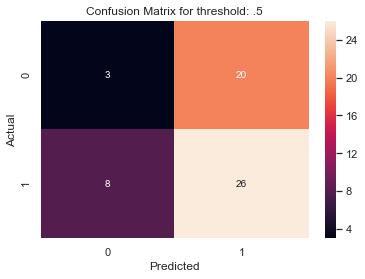

In [22]:
cm(y_test,prediction_test)

area under curve : 0.64


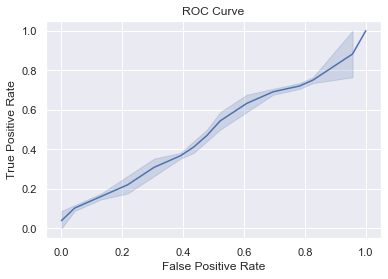

In [23]:
plotROC(y_test, df2019['pL1Logistic'])
print('area under curve : %.2f' %areaUnderROC(y_test, df2019['pL1Logistic']) )

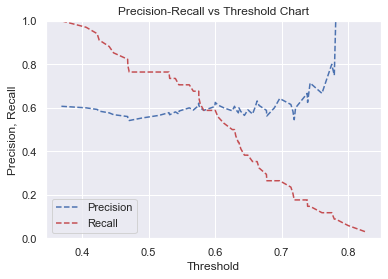

In [24]:
plotPrecisionRecallThreshold(y_test, df2019['pL1Logistic'])

AxesSubplot(0.125,0.125;0.775x0.755)


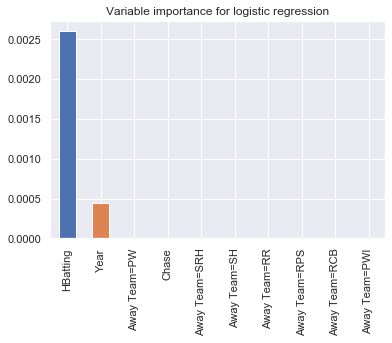

In [25]:
weights = pd.Series(model.coef_[0],index=X_train.columns)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar',title='Variable importance for logistic regression'))

In [26]:
#Logistic regression with Ridge CV
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(Cs=np.linspace(1e-7,1,100),cv=5,penalty='l2', random_state=232)
result = model.fit(X_train, y_train)
model.C_

array([0.01010111])

In [27]:
prediction_test = model.predict(X_train)
# Print the prediction accuracy
print('training accuracy: %.2f' %metrics.accuracy_score(y_train, prediction_test))
#df['logistic']=model.predict(X)
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print('test accuracy: %.2f' %metrics.accuracy_score(y_test, prediction_test))

training accuracy: 0.63
test accuracy: 0.51


In [28]:
df2019['L2Logistic']=prediction_test
df2019['pL2Logistic']=model.predict_proba(X_test)[:,1]

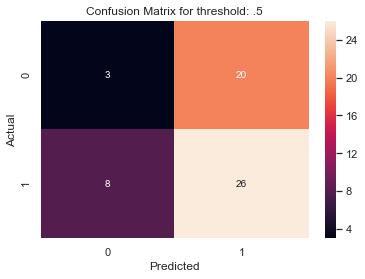

In [29]:
cm(y_test,prediction_test)

area under curve : 0.65


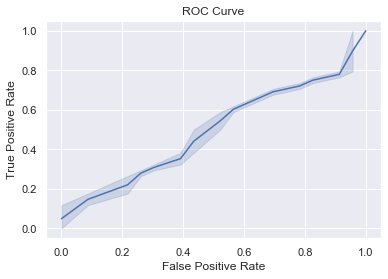

In [30]:
plotROC(y_test, df2019['pL2Logistic'])
print('area under curve : %.2f' %areaUnderROC(y_test, df2019['pL2Logistic']) )

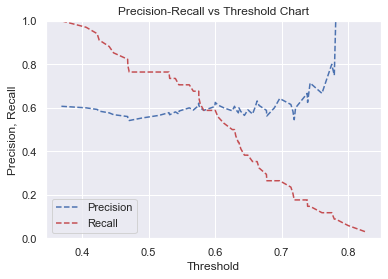

In [31]:
plotPrecisionRecallThreshold(y_test, df2019['pL1Logistic'])

AxesSubplot(0.125,0.125;0.775x0.755)


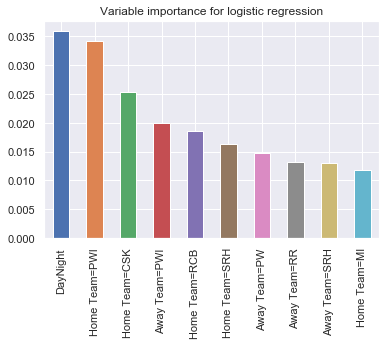

In [32]:
weights = pd.Series(model.coef_[0],index=X_train.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar',title='Variable importance for logistic regression'))

In [33]:
df2019.to_excel('/Users/shivam/Desktop/GL/Capstone/Reports/2019_predictions.xlsx')

In [34]:
#XGBoost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate   #Additional scklearn functions
from sklearn.model_selection import RandomizedSearchCV   #Perforing grid search
model=GradientBoostingClassifier(random_state=232)

In [35]:
model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=232, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [36]:
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)
#df['logisticCVL1']=model.predict(X)
# Print the prediction accuracy
print('accuracy %.2f' %(metrics.accuracy_score(y_test, prediction_test)))

accuracy 0.46


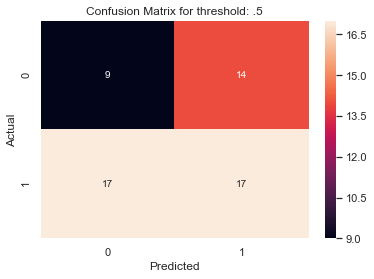

In [37]:
cm(y_test, prediction_test)

In [38]:
prediction_test = model.predict(X_train)
# Print the prediction accuracy
print('training accuracy: %.2f' %metrics.accuracy_score(y_train, prediction_test))
#df['logistic']=model.predict(X)
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print('test accuracy: %.2f' %metrics.accuracy_score(y_test, prediction_test))

training accuracy: 0.89
test accuracy: 0.46


In [39]:
df2019['XGBoost']=prediction_test
df2019['pXGBoost']=model.predict_proba(X_test)[:,1]

area under curve : 0.59


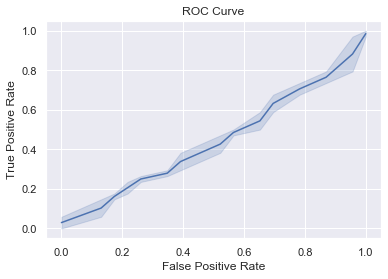

In [40]:
plotROC(y_test, df2019['pXGBoost'])
print('area under curve : %.2f' %areaUnderROC(y_test, df2019['pXGBoost']) )

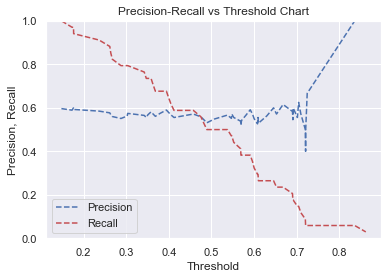

In [41]:
plotPrecisionRecallThreshold(y_test, df2019['pXGBoost'])

In [42]:
model.decision_function(X_test)

array([-1.54024883,  1.83334304, -0.63223679,  0.80492933,  0.63046021,
        0.94608028, -0.35545749, -1.02728682,  0.80780699, -0.83121248,
       -1.75184138,  0.40594552, -0.17061291,  0.3678052 ,  0.95018768,
        0.32492924, -0.5831864 , -1.56677681,  0.44829971,  0.0266337 ,
        0.86923089, -1.54239456,  0.8007405 , -0.49068506,  0.187512  ,
        0.39014572,  0.2783473 ,  0.4395507 , -0.83646718, -0.09933121,
        0.27571026, -0.5620056 , -0.0435005 ,  0.96782378, -1.00826831,
        0.15048522,  0.20999476,  0.44416199, -0.61550067, -0.65357239,
        0.69932111,  0.85534792, -0.53960629, -1.03893728,  0.19142549,
       -0.42960406,  0.60043388, -1.17333635,  0.94899377,  1.62982374,
       -0.40813637,  0.8943806 , -0.0719839 , -0.90706542,  0.53080922,
        0.28383208, -0.3852153 ])

In [43]:
model.score(X_test,y_test)

0.45614035087719296

In [44]:
model.feature_importances_

array([1.30359649e-01, 1.15230696e-01, 4.47292340e-02, 8.09396739e-03,
       9.42512047e-03, 0.00000000e+00, 3.99381500e-03, 1.26670827e-02,
       0.00000000e+00, 2.95536452e-04, 8.71189168e-03, 2.74019380e-05,
       0.00000000e+00, 1.76395818e-02, 0.00000000e+00, 0.00000000e+00,
       4.58530291e-03, 0.00000000e+00, 2.02044359e-02, 1.25894732e-02,
       1.53348977e-01, 7.67567932e-02, 7.89695463e-02, 1.42729336e-02,
       1.39097816e-03, 0.00000000e+00, 1.91607088e-03, 1.88719173e-02,
       1.81035225e-03, 8.54503773e-03, 4.12060423e-03, 2.17955876e-02,
       0.00000000e+00, 0.00000000e+00, 1.33123758e-02, 2.14839728e-03,
       7.20158677e-03, 0.00000000e+00, 7.62311616e-03, 1.99362537e-01])

AxesSubplot(0.125,0.125;0.775x0.755)


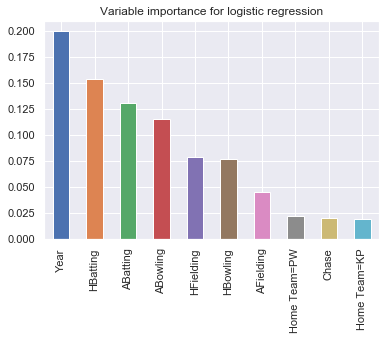

In [45]:
weights = pd.Series(model.feature_importances_,index=X_train.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar',title='Variable importance for logistic regression'))

In [46]:
?model

In [47]:
df2019.to_excel('/Users/shivam/Desktop/GL/Capstone/Reports/2019_predictions.xlsx')

In [86]:
#hidden_layer_sizes=(60,2)
#Neural Network
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(random_state=232)
model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=232, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [87]:
prediction_test = model.predict(X_train)
# Print the prediction accuracy
print('training accuracy: %.2f' %metrics.accuracy_score(y_train, prediction_test))
#df['logistic']=model.predict(X)
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print('test accuracy: %.2f' %metrics.accuracy_score(y_test, prediction_test))

training accuracy: 0.51
test accuracy: 0.46


In [88]:
df2019['NN']=prediction_test
df2019['pNN']=model.predict_proba(X_test)[:,1]

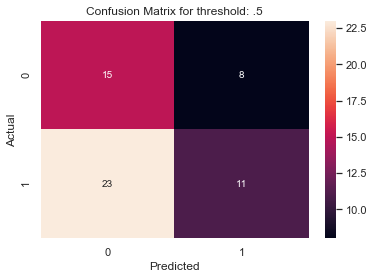

In [89]:
cm(y_test,prediction_test)

area under curve : 0.57


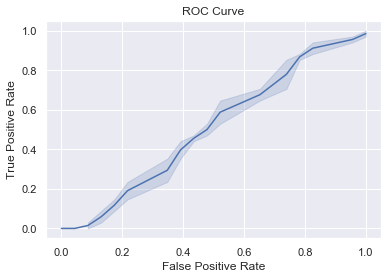

In [90]:
plotROC(y_test, df2019['pNN'])
print('area under curve : %.2f' %areaUnderROC(y_test, df2019['pNN']) )

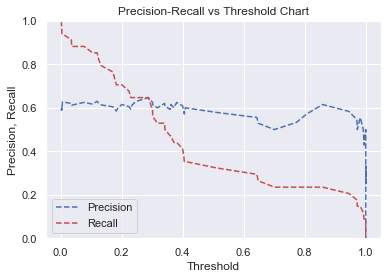

In [91]:
plotPrecisionRecallThreshold(y_test, df2019['pNN'])

In [92]:
prediction_test

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 0.])

In [93]:
model.n_layers_

3

In [94]:
df2019.to_excel('/Users/shivam/Desktop/GL/Capstone/Reports/2019_predictions.xlsx')